In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def id_splitter(df: pd.DataFrame) -> pd.DataFrame:
    parts = df["id"].str.split("_", expand=True)

    df["item_id"] = parts[0] + '_' + parts[1] + '_' + parts[2]
    df['store_id'] = parts[3] + '_' + parts[4]

    df.drop(columns=['id'], inplace=True)
    df.head()
    return df

In [3]:
calendar = pd.read_csv("data/calendar_afcs2024.csv")
calendar["date"] = pd.to_datetime(calendar["date"])
sell_prices = pd.read_csv("data/sell_prices_afcs2024.csv")
sales_train = id_splitter(pd.read_csv("data/sales_train_validation_afcs2024.csv"))
sales_test = id_splitter(pd.read_csv("data/sales_test_validation_afcs2024.csv"))
sales_test_evaluation = id_splitter(pd.read_csv("data/sales_test_evaluation_afcs_2024.csv"))
sample_submission = id_splitter(pd.read_csv("data/sample_submission_afcs2024.csv"))

In [4]:
prices_calendar = pd.merge(sell_prices, calendar, on="wm_yr_wk")
prices_calendar.head()

,store_id,item_id,wm_yr_wk,sell_price,date,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
0,TX_3,FOODS_3_001,11101,2.28,2011-01-29,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
1,TX_3,FOODS_3_001,11101,2.28,2011-01-30,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0
2,TX_3,FOODS_3_001,11101,2.28,2011-01-31,Monday,3,1,2011,NaN,NaN,NaN,NaN,0
3,TX_3,FOODS_3_001,11101,2.28,2011-02-01,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1
4,TX_3,FOODS_3_001,11101,2.28,2011-02-02,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,0


In [5]:
# # Select a sample of unique items for plotting
# # Find a dynamic way to select items based on parameters
# sample_items = merged_data['item_id'].unique()[:5]

# plt.figure(figsize=(14, 8))
# for item in sample_items:
#     item_data = merged_data[merged_data['item_id'] == item]
#     plt.plot(item_data['date'], item_data['sell_price'], label=f'Item: {item}')

# plt.title('Sell Prices of Selected Items Over Time')
# plt.xlabel('Date')
# plt.ylabel('Sell Price')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [6]:
sales_long = sales_train.melt(
    id_vars=["item_id", "store_id"],
    value_vars=[col for col in sales_train.columns if col.startswith("d_")],
    var_name="day",
    value_name="sales",
)

sales_long["day"] = sales_long["day"].str.extract(r"(\d+)").astype(int)

start_date = pd.Timestamp("2011-01-29")
sales_long["date"] = start_date + pd.to_timedelta(sales_long["day"] - 1, unit='d')
sales_long = sales_long.sort_values(by=["item_id", "date"])

train_data = pd.merge(
    sales_long,
    prices_calendar,
    on=["item_id", "store_id", "date"],
    how="left"
)
train_data = train_data.rename(columns={'Unnamed: 0': 'id'})

In [7]:
train_data.head()

,item_id,store_id,day,sales,date,wm_yr_wk,sell_price,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
0,FOODS_3_001,TX_3,1,0,2011-01-29,11101.0,2.28,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0
1,FOODS_3_001,TX_3,2,2,2011-01-30,11101.0,2.28,Sunday,2.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0
2,FOODS_3_001,TX_3,3,1,2011-01-31,11101.0,2.28,Monday,3.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0
3,FOODS_3_001,TX_3,4,3,2011-02-01,11101.0,2.28,Tuesday,4.0,2.0,2011.0,NaN,NaN,NaN,NaN,1.0
4,FOODS_3_001,TX_3,5,0,2011-02-02,11101.0,2.28,Wednesday,5.0,2.0,2011.0,NaN,NaN,NaN,NaN,0.0


In [8]:
price_trend = train_data.groupby("date")["sell_price"].mean()

sales_trend = train_data.groupby("date")["sales"].sum()

event_prices = train_data[train_data["event_name_1"].notnull()].groupby("date")["sell_price"].mean()
event_prices = train_data[train_data["event_name_2"].notnull()].groupby("date")["sell_price"].mean()

item_sales = train_data.groupby("item_id")["sales"].sum().sort_values(ascending=False)

item_prices = train_data.groupby("item_id")["sell_price"].max().sort_values(ascending=False)

top sales

In [9]:
top_items = item_sales.head(10)
top_items

item_id
FOODS_3_586    150122
FOODS_3_090    114854
FOODS_3_252     86632
FOODS_3_555     77673
FOODS_3_377     73797
FOODS_3_030     47976
FOODS_3_202     41551
FOODS_3_714     40650
FOODS_3_587     40306
FOODS_3_694     35152
Name: sales, dtype: int64

top prices

In [10]:
top_prices = item_prices.head(10)
top_prices

item_id
FOODS_3_083    19.48
FOODS_3_298    19.48
FOODS_3_173    13.98
FOODS_3_272    13.68
FOODS_3_110    11.98
FOODS_3_396    11.48
FOODS_3_690     9.98
FOODS_3_244     9.88
FOODS_3_242     9.88
FOODS_3_571     9.44
Name: sell_price, dtype: float64

bottom prices

In [11]:
bottom_prices = item_prices.tail(10)
bottom_prices

item_id
FOODS_3_580    0.25
FOODS_3_007    0.25
FOODS_3_070    0.25
FOODS_3_234    0.25
FOODS_3_547    0.25
FOODS_3_498    0.25
FOODS_3_454    0.25
FOODS_3_816    0.25
FOODS_3_412    0.25
FOODS_3_752    0.25
Name: sell_price, dtype: float64

I think the average does not really say much. I think it would be more useful to look at the extremes. There quite some items with much higher prices. However the volume of small priced items is just too great compared to the expensive items

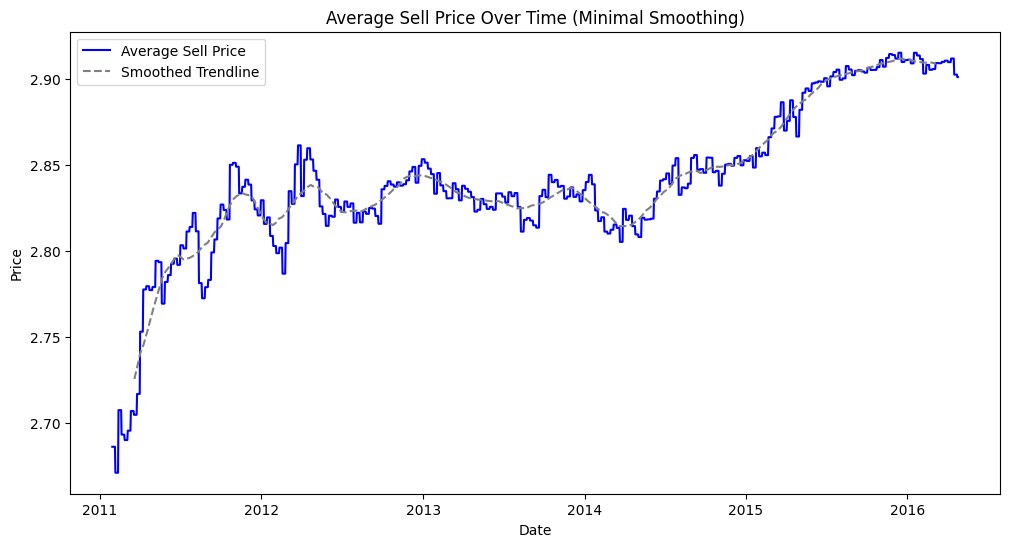

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=price_trend.index,
    y=price_trend.values,
    label="Average Sell Price",
    color="blue",
)
sns.lineplot(
    x=price_trend.index,
    y=price_trend.rolling(window=100, center=True).mean(),
    label="Smoothed Trendline",
    color="grey",
    linestyle="--",
)
plt.title("Average Sell Price Over Time (Minimal Smoothing)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

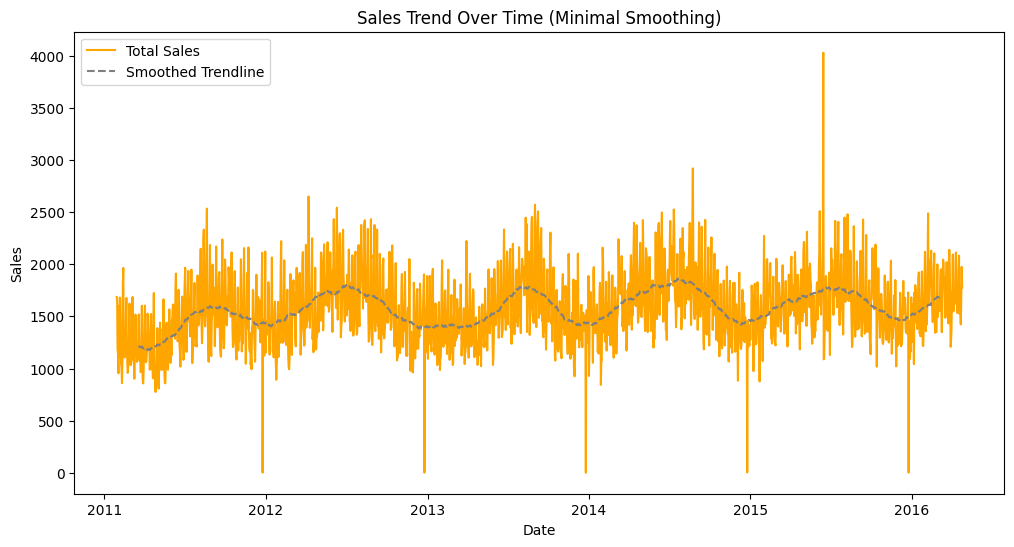

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=sales_trend.index,
    y=sales_trend.values,
    label="Total Sales",
    color="orange",
)
sns.lineplot(
    x=sales_trend.index,
    y=sales_trend.rolling(window=100, center=True).mean(),
    label="Smoothed Trendline",
    color="grey",
    linestyle="--",
)
plt.title("Sales Trend Over Time (Minimal Smoothing)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_20708\3363445687.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


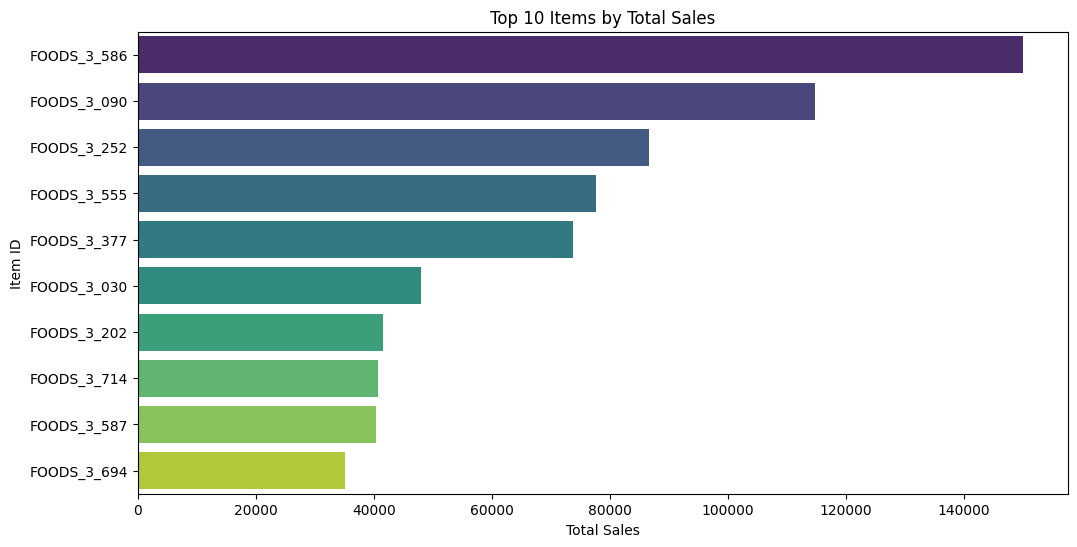

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_items.values,
    y=top_items.index,
    palette="viridis",
    orient="h",
)
plt.title("Top 10 Items by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_20708\170245651.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


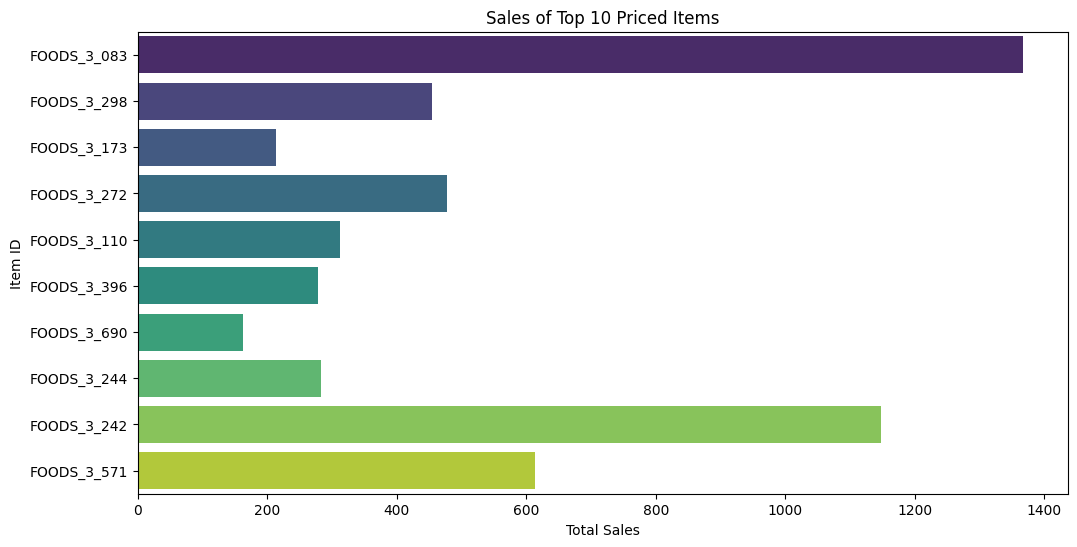

In [15]:
top_prices_ids = top_prices.index.tolist()

# Filter the sales data for the top-priced items
top_price_sales = item_sales.loc[top_prices_ids]

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_price_sales.values,
    y=top_price_sales.index,
    palette="viridis",
    orient="h",
)
plt.title("Sales of Top 10 Priced Items")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_20708\2505532345.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


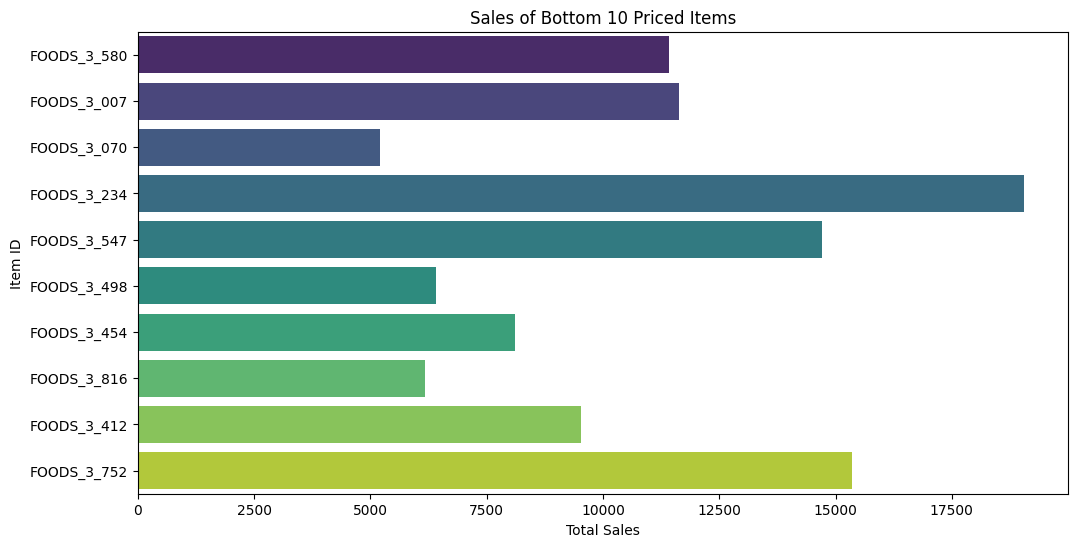

In [16]:
bottom_prices_ids = bottom_prices.index.tolist()

# Filter the sales data for the top-priced items
bottom_price_sales = item_sales.loc[bottom_prices_ids]

plt.figure(figsize=(12, 6))
sns.barplot(
    x=bottom_price_sales.values,
    y=bottom_price_sales.index,
    palette="viridis",
    orient="h",
)
plt.title("Sales of Bottom 10 Priced Items")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()

### Model selection

- Forecasting daily sales for the next 28 days in Texas

### ETS for the sales of all items (since there are signs of trend & seasonality ETS seems like a good choice)

- An additive model seems more appropiate as the seasonal variations and trends are roughly constant throughout the series.
- No sign of explonential growth in the trend or seasonality (multiplicative model).
- Source: https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html

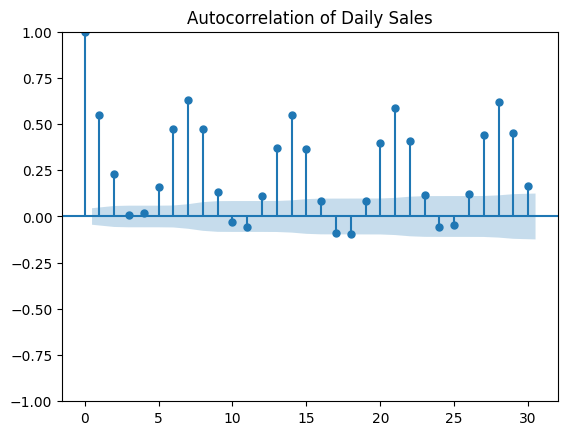

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sales_trend, lags=30)
plt.title('Autocorrelation of Daily Sales')
plt.show()
# confirms weekly seasonality

In [34]:
# Creating and fitting the ETS model
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
model = ETSModel(
    sales_trend,
    error="add",
    trend="add",
    seasonal="add",
    seasonal_periods=7,
)
ets_model = model.fit()

C:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [35]:
print(ets_model.summary())

                                 ETS Results                                  
Dep. Variable:                  sales   No. Observations:                 1913
Model:                       ETS(AAA)   Log Likelihood              -13085.639
Date:                Mon, 09 Dec 2024   AIC                          26197.278
Time:                        21:39:25   BIC                          26269.511
Sample:                    01-29-2011   HQIC                         26223.860
                         - 04-24-2016   Scale                        51168.252
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.2037      0.019     10.790      0.000       0.167       0.241
smoothing_trend        0.0009        nan        nan        nan         nan         nan
smoothing_seasonal  

In [36]:
ets_forecast = ets_model.forecast(28)
print(ets_forecast.round(2)) 

2016-04-25    1618.92
2016-04-26    1548.05
2016-04-27    1472.72
2016-04-28    1499.24
2016-04-29    1615.55
2016-04-30    1874.12
2016-05-01    1963.16
2016-05-02    1619.67
2016-05-03    1548.80
2016-05-04    1473.47
2016-05-05    1499.99
2016-05-06    1616.30
2016-05-07    1874.87
2016-05-08    1963.91
2016-05-09    1620.43
2016-05-10    1549.55
2016-05-11    1474.22
2016-05-12    1500.74
2016-05-13    1617.05
2016-05-14    1875.62
2016-05-15    1964.66
2016-05-16    1621.18
2016-05-17    1550.30
2016-05-18    1474.98
2016-05-19    1501.50
2016-05-20    1617.81
2016-05-21    1876.38
2016-05-22    1965.42
Freq: D, Name: simulation, dtype: float64


### Forecasting sales for the priciest item

In [52]:
# Selecting item with the highest price
expensive_item = train_data[(train_data['store_id'] == 'TX_3') & (train_data['item_id'] == 'FOODS_3_083')]

# Aggregating sales by date for this item
expensive_item_sales = expensive_item.groupby('date')['sales'].sum()

# Creating and fitting the ETS model
model_1 = ETSModel(
    item_sales_trend_tx3,
    error='add',
    trend='add',
    seasonal='add',
    seasonal_periods=7  
)
ets_model_1 = model_1.fit()

# Forecasting the next 28 days
forecast_expensive = ets_model_1.forecast(28)
print(forecast_expensive.round(2))

C:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2016-04-25    0.58
2016-04-26    0.53
2016-04-27    0.62
2016-04-28    0.70
2016-04-29    0.73
2016-04-30    0.94
2016-05-01    0.77
2016-05-02    0.58
2016-05-03    0.53
2016-05-04    0.61
2016-05-05    0.70
2016-05-06    0.73
2016-05-07    0.94
2016-05-08    0.77
2016-05-09    0.58
2016-05-10    0.53
2016-05-11    0.61
2016-05-12    0.70
2016-05-13    0.73
2016-05-14    0.94
2016-05-15    0.77
2016-05-16    0.58
2016-05-17    0.53
2016-05-18    0.61
2016-05-19    0.70
2016-05-20    0.73
2016-05-21    0.94
2016-05-22    0.77
Freq: D, Name: simulation, dtype: float64


### Forecasting sales for the cheapest item

In [53]:
# Selecting one of the items with lowest price (there were several with the same price)
cheapest_item = train_data[(train_data['store_id'] == 'TX_3') & (train_data['item_id'] == 'FOODS_3_580')]

# Aggregating sales by date for this item
cheapest_item_sales = cheapest_item.groupby('date')['sales'].sum()

# Creating and fitting the ETS model
model_2 = ETSModel(
    cheapest_item_sales,
    error='add',
    trend='add',
    seasonal='add',
    seasonal_periods=7  
)
ets_model_2 = model_2.fit()

# Forecasting the next 28 days
forecast_cheapest = ets_model_2.forecast(28)
print(forecast_cheapest.round(2))

C:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2016-04-25    1.28
2016-04-26   -0.13
2016-04-27   -0.91
2016-04-28   -0.61
2016-04-29   -0.99
2016-04-30   -0.39
2016-05-01    1.20
2016-05-02    1.24
2016-05-03   -0.17
2016-05-04   -0.95
2016-05-05   -0.65
2016-05-06   -1.03
2016-05-07   -0.43
2016-05-08    1.16
2016-05-09    1.20
2016-05-10   -0.21
2016-05-11   -0.99
2016-05-12   -0.69
2016-05-13   -1.07
2016-05-14   -0.47
2016-05-15    1.12
2016-05-16    1.16
2016-05-17   -0.25
2016-05-18   -1.03
2016-05-19   -0.73
2016-05-20   -1.11
2016-05-21   -0.51
2016-05-22    1.08
Freq: D, Name: simulation, dtype: float64


In [51]:
# don't understand what the negative sales mean (did i do something wrong?)

### Now lets compare it to the item with the most sales

In [50]:
# Selecting most sold item 
popular_item = train_data[(train_data['store_id'] == 'TX_3') & (train_data['item_id'] == 'FOODS_3_586')]

# Aggregating sales by date for this item
popular_item_sales = popular_item.groupby('date')['sales'].sum()

# Creating and fitting the ETS model
model_3 = ETSModel(
    popular_item_sales,
    error='add',
    trend='add',
    seasonal='add',
    seasonal_periods=7  
)
ets_model_3 = model_3.fit()

# Forecasting the next 28 days
forecast_popular = ets_model_3.forecast(28)
print(forecast_popular.round(2))

C:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2016-04-25    47.52
2016-04-26    44.18
2016-04-27    44.30
2016-04-28    47.37
2016-04-29    53.19
2016-04-30    65.86
2016-05-01    64.13
2016-05-02    47.40
2016-05-03    44.05
2016-05-04    44.18
2016-05-05    47.24
2016-05-06    53.07
2016-05-07    65.74
2016-05-08    64.00
2016-05-09    47.27
2016-05-10    43.93
2016-05-11    44.05
2016-05-12    47.12
2016-05-13    52.94
2016-05-14    65.61
2016-05-15    63.87
2016-05-16    47.14
2016-05-17    43.80
2016-05-18    43.93
2016-05-19    46.99
2016-05-20    52.81
2016-05-21    65.49
2016-05-22    63.75
Freq: D, Name: simulation, dtype: float64
